# Prepocessing

In [1]:
# ================== PREPROCESS YOUTUBE DATA ==================
import re
import numpy as np
import pandas as pd
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

# NLTK setup
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

def safe_ratio(n, d): 
    return n / np.where(d==0, 1, d)

#Convert ISO8601 duration into seconds.
def parse_iso8601_seconds(s):
    if pd.isna(s): 
        return np.nan
    m = re.fullmatch(r"PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?", str(s))
    return (int(m.group(1) or 0)*3600 + int(m.group(2) or 0)*60 + int(m.group(3) or 0)) if m else np.nan

# Lowercase, strip punctuation/numbers, tokenize, remove stopwords, lemmatize.
def clean_text(t):
    t = re.sub(r"[^a-z\s]", "", str(t).lower())
    return " ".join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(t) if w not in stop_words)

# Load Datasets
meta = pd.read_csv("combined_youtube.csv")
snap = pd.read_csv("combined_engagement.csv")

snap = snap.query("0 <= snapshot_day <= 7").sort_values(["video_id","snapshot_day","timestamp"])
snap = snap.drop_duplicates(["video_id","snapshot_day"], keep="last")

# Pivot each metric into wide form
views_w    = snap.pivot(index="video_id", columns="snapshot_day", values="view_count").add_prefix("views_d")
likes_w    = snap.pivot(index="video_id", columns="snapshot_day", values="like_count").add_prefix("likes_d")
comments_w = snap.pivot(index="video_id", columns="snapshot_day", values="comment_count").add_prefix("comments_d")
wide = pd.concat([views_w, likes_w, comments_w], axis=1).reset_index()

# Clean metadata
meta["publish_time"] = pd.to_datetime(meta["publish_time"], errors="coerce")

# Keep the earliest upload per video_id
meta = meta.sort_values("publish_time").drop_duplicates("video_id", keep="first")

# Parse duration
meta["duration_sec"] = meta["duration"].map(parse_iso8601_seconds)

# Process raw text
meta["tags_text"] = meta["tags"].astype(str).str.replace(r"[|,;\[\]']", " ", regex=True)
for col in ["title","description","tags_text"]:
    meta[f"{col}_clean"] = meta[col].fillna("").map(clean_text)

# Merge
df = meta.merge(wide, on="video_id", how="left")

# Day 0 & 1 like to view and comment to view ratios
for d in [0,1]:
    df[f"day{d}_like_view"]    = safe_ratio(df[f"likes_d{d}"].fillna(0), df[f"views_d{d}"].fillna(0))
    df[f"day{d}_comment_view"] = safe_ratio(df[f"comments_d{d}"].fillna(0), df[f"views_d{d}"].fillna(0))

# Label
er = df[["likes_d7","comments_d7"]].fillna(0).sum(axis=1)
df["eng_rate_day7"] = safe_ratio(er, df["views_d7"].fillna(0))
med_v7 = df["views_d7"].median(skipna=True)
df["label_trending"] = ((df["eng_rate_day7"] > 0.05) & (df["views_d7"] >= med_v7)).astype("Int64")

# Sentiment score for title and description
df["sent_title"] = df["title"].map(lambda x: sia.polarity_scores(str(x))["compound"])
df["sent_desc"]  = df["description"].map(lambda x: sia.polarity_scores(str(x))["compound"])

# Save only required columns
keep = [
    "video_id","publish_time","channel_title","title","description","tags_text",
    "title_clean","description_clean","tags_text_clean",
    "channel_subscriber_count","channel_video_count","duration_sec",
    "views_d0","likes_d0","comments_d0","day0_like_view","day0_comment_view",
    "views_d1","likes_d1","comments_d1","day1_like_view","day1_comment_view",
    "views_d7","likes_d7","comments_d7","eng_rate_day7","label_trending",
    "sent_title","sent_desc"
]

df_save = df[keep]

# Save to csv
df_save.to_csv("yt_final_with_sentiment.csv", index=False)
print("Saved yt_final_with_sentiment.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dreamdevil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dreamdevil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dreamdevil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dreamdevil/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Saved yt_final_with_sentiment.csv


In [2]:
# Split data into training & test set
df_final = pd.read_csv("yt_final_with_sentiment.csv")

text_cols = ["title_clean", "tags_text_clean", "description_clean"]
num_cols = [
    "duration_sec", "channel_subscriber_count", "channel_video_count",
    "views_d1", "likes_d1", "comments_d1",
    "day1_like_view", "day1_comment_view",
    "sent_title", "sent_desc"
]

for col in text_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna("").astype(str)
        
for col in num_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0.0)
        
all_features = text_cols + num_cols
target = "label_trending"

X = df_final[all_features].copy()
y = df_final[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Exploratory Data Analysis

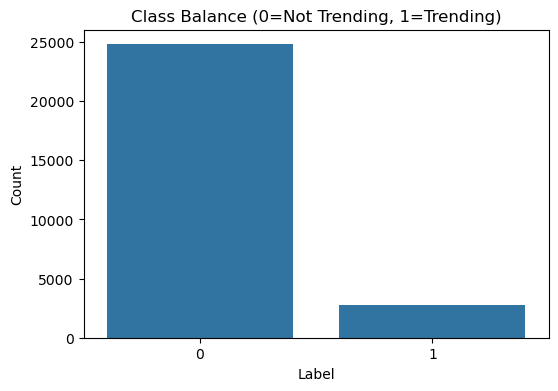

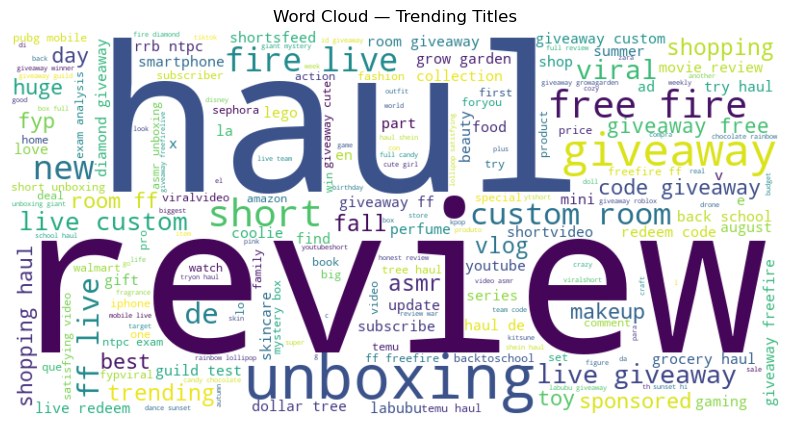

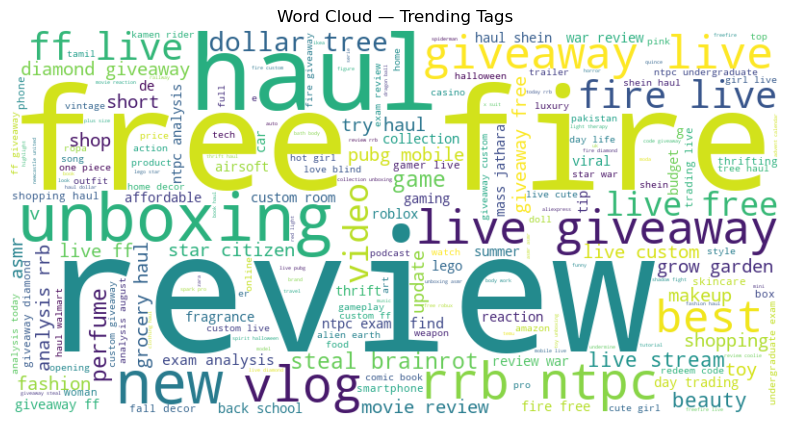

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Class imbalance plot
plt.figure(figsize=(6,4))
sns.countplot(x="label_trending", data=df_final)
plt.title("Class Balance (0=Not Trending, 1=Trending)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Word cloud — Trending Titles
trending_titles = " ".join(df_final.loc[df_final["label_trending"]==1, "title_clean"].dropna().astype(str))
wc_titles = WordCloud(width=800, height=400, background_color="white").generate(trending_titles)
plt.figure(figsize=(10,5))
plt.imshow(wc_titles, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Trending Titles")
plt.show()

# Word cloud — Trending Tags
trending_tags = " ".join(df_final.loc[df_final["label_trending"]==1, "tags_text_clean"].dropna().astype(str))
wc_tags = WordCloud(width=800, height=400, background_color="white").generate(trending_tags)
plt.figure(figsize=(10,5))
plt.imshow(wc_tags, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Trending Tags")
plt.show()


# Baseline model

Baseline:
              precision    recall  f1-score   support

           0      0.899     1.000     0.947      4962
           1      0.000     0.000     0.000       555

    accuracy                          0.899      5517
   macro avg      0.450     0.500     0.474      5517
weighted avg      0.809     0.899     0.852      5517

Precision: 0.000
Recall:    0.000
F1-score:  0.000
Average Precision: 0.101


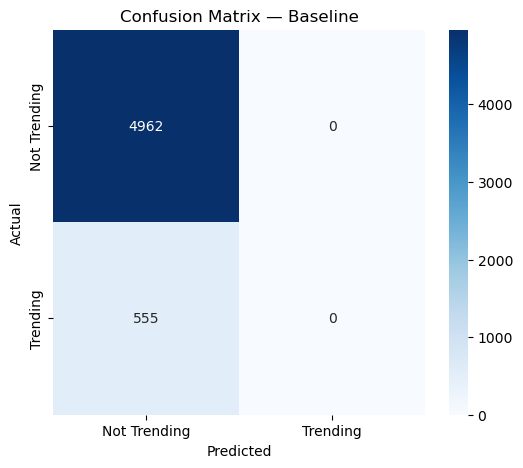

In [4]:
# ================== STEP 3: Baseline — Majority Class ==================

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, accuracy_score, precision_score, recall_score, f1_score


# Baseline model (majority class)
clf = DummyClassifier(strategy="most_frequent", random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Baseline:")
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

ap   = average_precision_score(y_test, y_proba)
precison = precision_score(y_test, y_pred, zero_division=0)
recall  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print(f"Precision: {precison:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Average Precision: {ap:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Trending","Trending"],
            yticklabels=["Not Trending","Trending"])
plt.title("Confusion Matrix — Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Logistic Regression with TF-IDF

Logistic Regression + TF-IDF:
              precision    recall  f1-score   support

           0      0.992     0.873     0.928      4962
           1      0.450     0.933     0.608       555

    accuracy                          0.879      5517
   macro avg      0.721     0.903     0.768      5517
weighted avg      0.937     0.879     0.896      5517

Precision: 0.450
Recall:    0.933
F1-score:  0.608
PR-AUC: 0.828


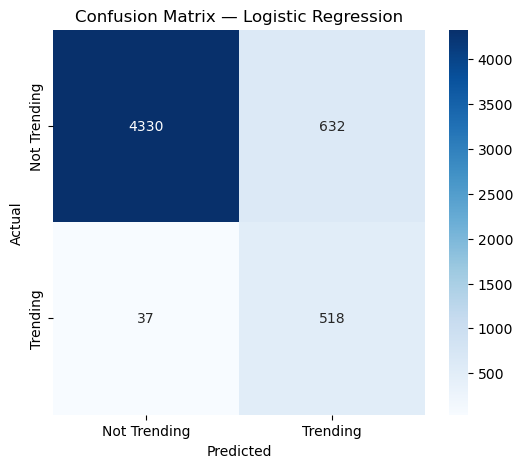

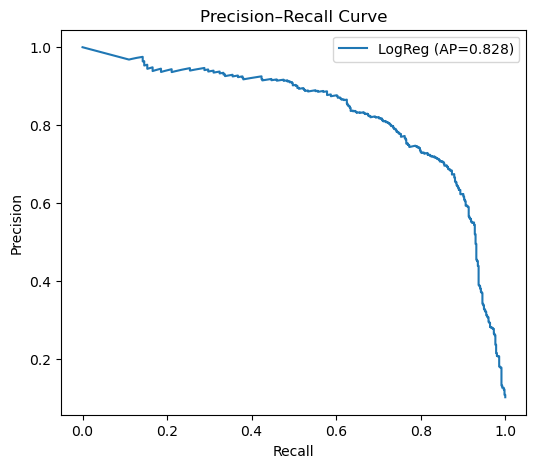

In [5]:
# ================== Logistic Regression with TF-IDF ==================
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

tfidf_title = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=3)
tfidf_tags = TfidfVectorizer(ngram_range=(1,2), max_features=12000, min_df=3)
tfidf_desc = TfidfVectorizer(ngram_range=(1,1), max_features=12000, min_df=6)


# Column-wise preprocessing
pre = ColumnTransformer([
    ("tfidf_title", tfidf_title, "title_clean"),
    ("tfidf_tags",  tfidf_tags, "tags_text_clean"),
    ("tfidf_desc",  tfidf_desc, "description_clean"),
    ("num", "passthrough", num_cols),
])

# Logistic regression model
lr_model = LogisticRegression(class_weight="balanced", solver='lbfgs')

# Pipeline
pipe = Pipeline([("pre", pre), ("clf", lr_model)])
pipe.fit(X_train, y_train)

# Predictions
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression + TF-IDF:")
print(classification_report(y_test, y_pred, digits=3))

ap = average_precision_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"PR-AUC: {ap:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Trending","Trending"],
            yticklabels=["Not Trending","Trending"])
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision–Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label=f"LogReg (AP={ap:.3f})")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


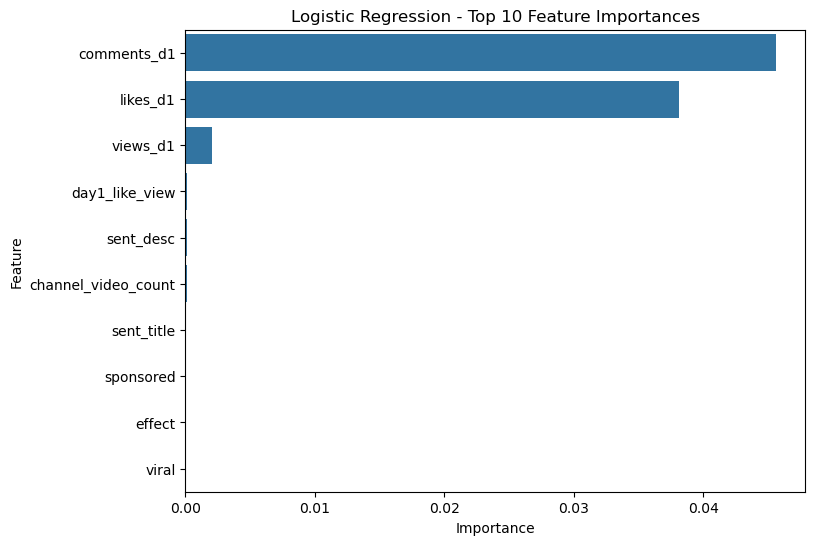

In [6]:
# Feature Importance graph
# Extract feature names from ColumnTransformer
feature_names = []
for name, transformer, cols in pre.transformers_:
    if name.startswith("tfidf"):
        feature_names.extend(transformer.get_feature_names_out())
    elif name == "num":
        feature_names.extend(cols)

# Get coefficients from logistic regression
coefs = pipe.named_steps["clf"].coef_[0]

# Combine into DataFrame
feat_imp = pd.DataFrame({"feature": feature_names, "coef": coefs})
feat_imp["importance"] = feat_imp["coef"].abs()

# Top 10 influential features
top_features = feat_imp.sort_values("importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=top_features, x="importance", y="feature")
plt.title("Logistic Regression - Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Random Forest with TF-IDF

Random Forest with SVD-TF-IDF:
              precision    recall  f1-score   support

           0      0.990     0.961     0.975      4962
           1      0.721     0.910     0.805       555

    accuracy                          0.956      5517
   macro avg      0.856     0.935     0.890      5517
weighted avg      0.963     0.956     0.958      5517

Precision: 0.721
Recall:    0.910
F1-score:  0.805
PR-AUC: 0.901


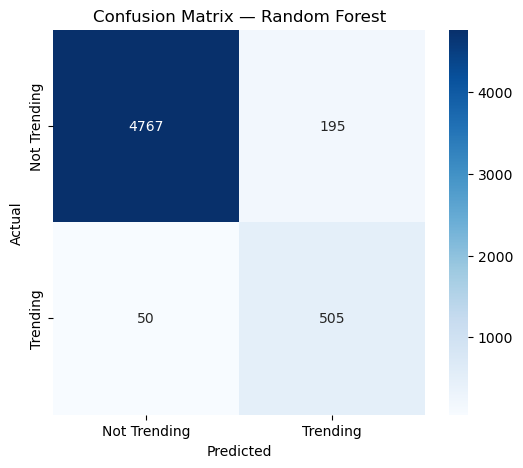

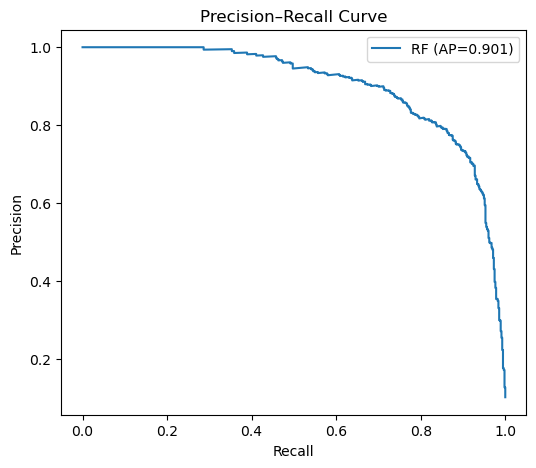

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

# TF-IDF
Xtrain_title = tfidf_title.fit_transform(X_train["title_clean"])
Xtrain_tags  = tfidf_tags.fit_transform(X_train["tags_text_clean"])
Xtrain_desc  = tfidf_desc.fit_transform(X_train["description_clean"])
Xtrain_text  = hstack([Xtrain_title, Xtrain_tags, Xtrain_desc], format="csr")

Xtest_title = tfidf_title.transform(X_test["title_clean"])
Xtest_tags  = tfidf_tags.transform(X_test["tags_text_clean"])
Xtest_desc  = tfidf_desc.transform(X_test["description_clean"])
Xtest_text  = hstack([Xtest_title, Xtest_tags, Xtest_desc], format="csr")

# SVD compression
svd = TruncatedSVD(n_components=200, random_state=42)
Xtrain_text_svd = svd.fit_transform(Xtrain_text)
Xtest_text_svd = svd.transform(Xtest_text)

# Combine numeric & text features
X_train_comb = np.concatenate([X_train[num_cols], Xtrain_text_svd], axis=1)
X_test_comb  = np.concatenate([X_test[num_cols],  Xtest_text_svd], axis=1)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight="balanced_subsample"
)
rf_model.fit(X_train_comb, y_train)

# Predictions
y_pred  = rf_model.predict(X_test_comb)
y_proba = rf_model.predict_proba(X_test_comb)[:, 1]

# Evaluation
print("Random Forest with SVD-TF-IDF:")
print(classification_report(y_test, y_pred, digits=3))

ap = average_precision_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"PR-AUC: {ap:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Trending","Trending"],
            yticklabels=["Not Trending","Trending"])
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision–Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label=f"RF (AP={ap:.3f})")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


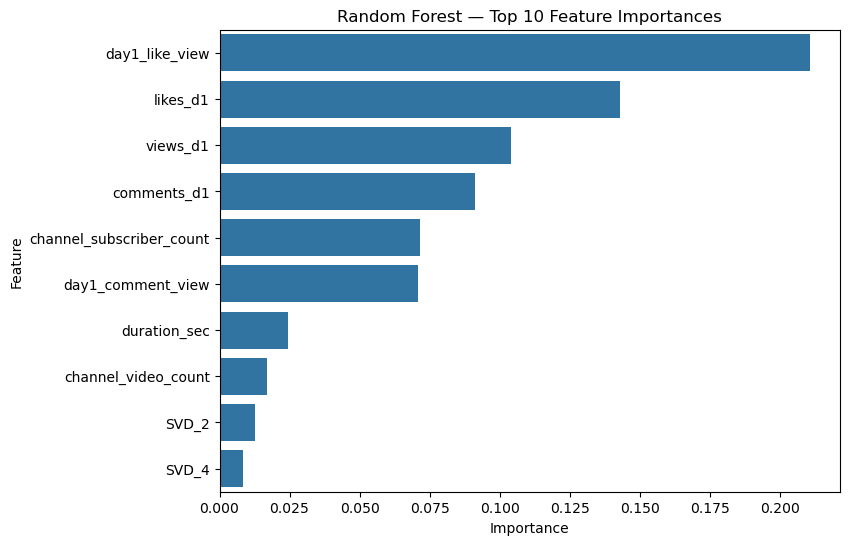


Top terms for the most important SVD components:

SVD_2 : fire, giveaway, free, live, live, giveaway, free, live, fire, free fire
SVD_4 : giveaway, roblox, growagarden, garden, grow, grow garden, giveaway roblox, roblox, giveaway, stealabrainrot


In [9]:
# Feature Importance Graph
feat_names = num_cols + [f"SVD_{i+1}" for i in range(svd.n_components)]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:10] 

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=np.array(feat_names)[indices])
plt.title("Random Forest — Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Show which terms dominate the important SVD components
if hasattr(svd, "components_"):
    tfidf_vocab = (
        list(tfidf_title.get_feature_names_out()) +
        list(tfidf_tags.get_feature_names_out()) +
        list(tfidf_desc.get_feature_names_out())
    )

    print("\nTop terms for the most important SVD components:\n")
    for idx in indices:
        if "SVD_" in feat_names[idx]:
            comp_id = int(feat_names[idx].split("_")[1]) - 1
            comp = svd.components_[comp_id]
            top_terms = np.array(tfidf_vocab)[np.argsort(comp)[-10:][::-1]]
            print(f"{feat_names[idx]} : {', '.join(top_terms)}")


# LSTM with TD-IDF

In [10]:
 # ================== LSTM (Seq + Static + SVD-TF-IDF) ==================
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras import layers, models, callbacks


# Columns
seq_cols_d0 = ["views_d0", "likes_d0", "comments_d0"]
seq_cols_d1 = ["views_d1", "likes_d1", "comments_d1"]
lstm_num_cols = [
    "duration_sec", "channel_subscriber_count", "channel_video_count",
    "day1_like_view", "day1_comment_view",
    "sent_title", "sent_desc"
]
text_cols = ["title_clean", "tags_text_clean", "description_clean"]

# Fill missing
df[seq_cols_d0 + seq_cols_d1 + lstm_num_cols] = df[seq_cols_d0 + seq_cols_d1 + lstm_num_cols].fillna(0.0)

X_text = df[text_cols]
X_num  = df[lstm_num_cols].values
X_seq0 = df[seq_cols_d0].values
X_seq1 = df[seq_cols_d1].values

# Split data into train/test
X_train_text, X_test_text, X_train_num, X_test_num, X_train_seq0, X_test_seq0, X_train_seq1, X_test_seq1, y_train, y_test = train_test_split(
    X_text, X_num, X_seq0, X_seq1, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF + SVD 
X_train_title = tfidf_title.fit_transform(X_train_text["title_clean"])
X_train_tags  = tfidf_tags.fit_transform(X_train_text["tags_text_clean"])
X_train_desc  = tfidf_desc.fit_transform(X_train_text["description_clean"])
X_train_text_sparse = hstack([X_train_title, X_train_tags, X_train_desc], format="csr")

X_test_title = tfidf_title.transform(X_test_text["title_clean"])
X_test_tags  = tfidf_tags.transform(X_test_text["tags_text_clean"])
X_test_desc  = tfidf_desc.transform(X_test_text["description_clean"])
X_test_text_sparse = hstack([X_test_title, X_test_tags, X_test_desc], format="csr")

svd = TruncatedSVD(n_components=200, random_state=42)
X_train_text_svd = svd.fit_transform(X_train_text_sparse)
X_test_text_svd = svd.transform(X_test_text_sparse)

2025-09-22 09:21:57.724374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4130 - pr_auc: 0.4925 - val_loss: 0.2944 - val_pr_auc: 0.7410
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2591 - pr_auc: 0.6838 - val_loss: 0.1697 - val_pr_auc: 0.8599
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2247 - pr_auc: 0.7942 - val_loss: 0.2067 - val_pr_auc: 0.8580
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2119 - pr_auc: 0.8136 - val_loss: 0.1846 - val_pr_auc: 0.8629
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1825 - pr_auc: 0.8532 - val_loss: 0.2221 - val_pr_auc: 0.8650
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1918 - pr_auc: 0.8369 - val_loss: 0.1635 - val_pr_auc: 0.8679
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1812 - pr_auc: 0.8643 - val_loss: 0.1678 - val_pr_auc: 0.8537
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1711 - pr_auc: 0.8558 - val_loss: 0.1589 - val_pr_auc: 0.8854
Epoch 9/

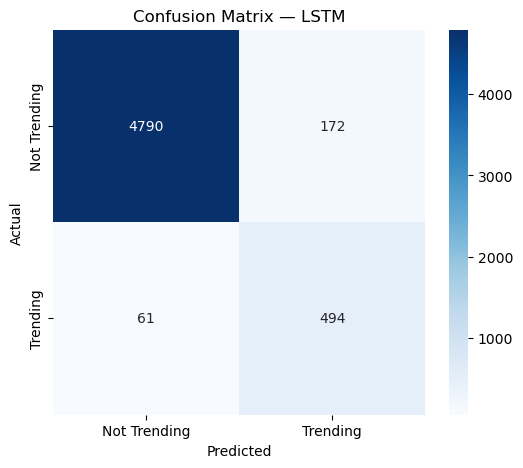

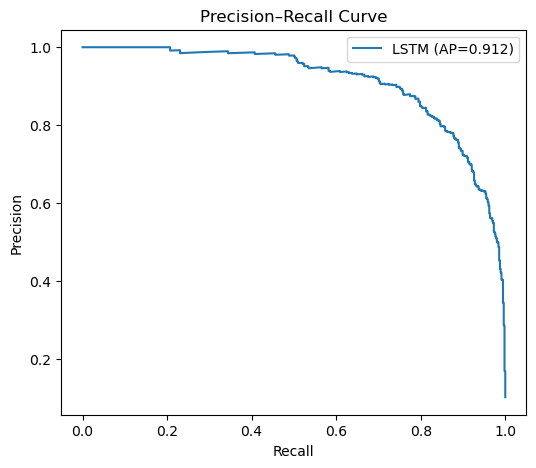

In [12]:
# LSTM inputs
X_train_seq = np.log1p(np.stack([X_train_seq0, X_train_seq1], axis=1).astype(np.float32))
X_test_seq = np.log1p(np.stack([X_test_seq0, X_test_seq1], axis=1).astype(np.float32))

X_train_static = np.concatenate([X_train_num, X_train_text_svd], axis=1)
X_test_static = np.concatenate([X_test_num, X_test_text_svd], axis=1)

# Scale
TIMESTEPS, FEATS = X_train_seq.shape[1], X_train_seq.shape[2]
seq_scaler = StandardScaler()
X_train_seq_s = seq_scaler.fit_transform(X_train_seq.reshape(-1, FEATS)).reshape(X_train_seq.shape[0], TIMESTEPS, FEATS)
X_test_seq_s = seq_scaler.transform(X_test_seq.reshape(-1, FEATS)).reshape(X_test_seq.shape[0], TIMESTEPS, FEATS)

sta_scaler = StandardScaler()
X_train_static_s = sta_scaler.fit_transform(X_train_static)
X_test_static_s = sta_scaler.transform(X_test_static)

# Class weights
weights = compute_class_weight("balanced", classes=[0, 1], y=y_train)
class_weight = dict(enumerate(weights))

# Sequence branch (time-series features)
seq_input = layers.Input(shape=(TIMESTEPS, FEATS))
seq_masked = layers.Masking(mask_value=0.0)(seq_input)
seq_lstm   = layers.LSTM(32, dropout=0.1)(seq_masked)
seq_dense  = layers.Dense(32, activation="relu")(seq_lstm)

# Static branch (numeric + SVD-TF-IDF features)
static_input = layers.Input(shape=(X_train_static_s.shape[1],))
static_dense1 = layers.Dense(64, activation="relu")(static_input)
static_drop   = layers.Dropout(0.1)(static_dense1)
static_dense2 = layers.Dense(32, activation="relu")(static_drop)

# Merge sequence + static
merged = layers.Concatenate()([seq_dense, static_dense2])
merged_dense = layers.Dense(32, activation="relu")(merged)
merged_drop  = layers.Dropout(0.1)(merged_dense)

# Output layer
output = layers.Dense(1, activation="sigmoid")(merged_drop)

# Define model
model = models.Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[AUC(curve="PR", name="pr_auc")])

# Train
es = callbacks.EarlyStopping(monitor="val_pr_auc", patience=5, restore_best_weights=True)
model.fit(
    [X_train_seq_s, X_train_static_s],
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1
)

# Evaluate
y_proba = model.predict([X_test_seq_s, X_test_static_s]).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("LSTM with SVD-TF-IDF:")
print(classification_report(y_test, y_pred, digits=3))
ap = average_precision_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"PR-AUC: {ap:.3f}")


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Trending","Trending"],
            yticklabels=["Not Trending","Trending"])
plt.title("Confusion Matrix — LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# PR Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"LSTM (AP={ap:.3f})")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Hyperparameters Tuning

In [15]:
# Hyperparameters to search
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.002, 0.003, 0.005]
lstm_units = [32, 64, 128]      
dense_units = [32, 64, 128]     
batch_sizes = [32, 64]

results = []

for dr in dropout_rates:
    for lr in learning_rates:
        for bs in batch_sizes:
            for lu in lstm_units:
                for du in dense_units:
                    print(f"\nTraining model with Dropout={dr}, LR={lr}, BS={bs}, LSTM={lu}, Dense={du}")

                    # Sequence branch
                    seq_input = layers.Input(shape=(TIMESTEPS, FEATS))
                    x = layers.Masking(mask_value=0.0)(seq_input)
                    x = layers.LSTM(lu, dropout=dr)(x)
                    x = layers.Dense(du, activation="relu")(x)

                    # Static branch
                    static_input = layers.Input(shape=(X_train_static_s.shape[1],))
                    s = layers.Dense(du*2, activation="relu")(static_input)
                    s = layers.Dropout(dr)(s)
                    s = layers.Dense(du, activation="relu")(s)

                    # Merge
                    merged = layers.Concatenate()([x, s])
                    merged = layers.Dense(du, activation="relu")(merged)
                    merged = layers.Dropout(dr)(merged)
                    out = layers.Dense(1, activation="sigmoid")(merged)

                    model = models.Model(inputs=[seq_input, static_input], outputs=out)
                    model.compile(
                        optimizer=Adam(learning_rate=lr),
                        loss="binary_crossentropy",
                        metrics=[tf.keras.metrics.AUC(curve="PR", name="pr_auc")]
                    )

                    # Early stopping
                    es = callbacks.EarlyStopping(
                        monitor="val_pr_auc", patience=5, restore_best_weights=True
                    )

                    # Train
                    model.fit(
                        [X_train_seq_s, X_train_static_s], y_train,
                        validation_split=0.1,
                        epochs=100,
                        batch_size=bs,
                        class_weight=class_weight,
                        callbacks=[es],
                        verbose=0
                    )

                    # Evaluate
                    y_proba = model.predict([X_test_seq_s, X_test_static_s]).ravel()

                    ap = average_precision_score(y_test, y_proba)

                    # Save results
                    results.append({
                        "Dropout": dr,
                        "Learning Rate": lr,
                        "Batch Size": bs,
                        "LSTM Units": lu,
                        "Dense Units": du,
                        "PR-AUC": ap
                    })

# Show all results sorted by PR-AUC
import pandas as pd
results_df = pd.DataFrame(results).sort_values("PR-AUC", ascending=False)
print("\nHyperparameter Search Results")
print(results_df.head(3))  



Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=32, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=32, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=32, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=64, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=64, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=64, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=128, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=128, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.001, BS=32, LSTM=128, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Tra

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.005, BS=32, LSTM=64, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training model with Dropout=0.1, LR=0.005, BS=32, LSTM=64, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.005, BS=32, LSTM=64, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.005, BS=32, LSTM=128, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.005, BS=32, LSTM=128, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.005, BS=32, LSTM=128, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.1, LR=0.005, BS=64, LSTM=32, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training model with Dropout=0.1, LR=0.005, BS=64, LSTM=32, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training model with Dropout=0.1, LR=0.005, BS=64, LSTM=32, Dense=128
173/

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

Training model with Dropout=0.2, LR=0.003, BS=32, LSTM=64, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Training model with Dropout=0.2, LR=0.003, BS=32, LSTM=128, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Training model with Dropout=0.2, LR=0.003, BS=32, LSTM=128, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Training model with Dropout=0.2, LR=0.003, BS=32, LSTM=128, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

Training model with Dropout=0.2, LR=0.003, BS=64, LSTM=32, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Training model with Dropout=0.2, LR=0.003, BS=64, LSTM=32, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Training model with Dropout=0.2, LR=0.003, BS=64, LSTM=32, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Training model with Dropout=0.2, LR=0.003, BS=64, LSTM=64, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Training model with Dropout=0.2, LR=0.003, BS=64, LSTM=64, Dense=64
1

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Training model with Dropout=0.3, LR=0.002, BS=32, LSTM=128, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=32, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=32, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=32, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=64, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=64, Dense=64
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=64, Dense=128
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=128, Dense=32
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Training model with Dropout=0.3, LR=0.002, BS=64, LSTM=128, Dense=64
17

Epoch 1/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3736 - pr_auc: 0.5078 - val_loss: 0.3677 - val_pr_auc: 0.6878
Epoch 2/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2609 - pr_auc: 0.7328 - val_loss: 0.2241 - val_pr_auc: 0.8106
Epoch 3/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2406 - pr_auc: 0.7533 - val_loss: 0.3645 - val_pr_auc: 0.7248
Epoch 4/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2210 - pr_auc: 0.7772 - val_loss: 0.1714 - val_pr_auc: 0.8489
Epoch 5/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2010 - pr_auc: 0.8353 - val_loss: 0.1241 - val_pr_auc: 0.8937
Epoch 6/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2165 - pr_auc: 0.8203 - val_loss: 0.2203 - val_pr_auc: 0.9006
Epoch 7/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1929 - pr_auc: 0.8182 - val_loss: 0.2092 - val_pr_auc: 0.9174
Epoch 8/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1927 - pr_auc: 0.8365 - val_loss: 0.1117 - val_pr_auc: 0.9237

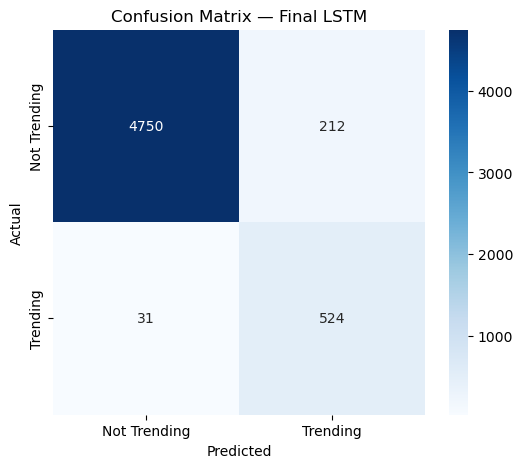

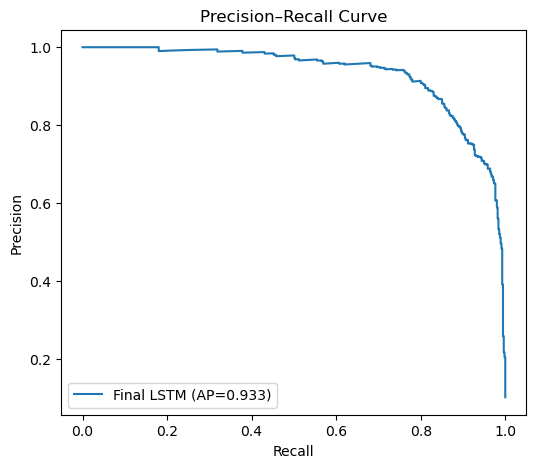

In [17]:
# Sequence branch (time-series features)
seq_input = layers.Input(shape=(TIMESTEPS, FEATS))
seq_masked = layers.Masking(mask_value=0.0)(seq_input)
seq_lstm   = layers.LSTM(32, dropout=0.1)(seq_masked)
seq_dense  = layers.Dense(128, activation="relu")(seq_lstm)

# Static branch (numeric + SVD-TF-IDF features)
static_input = layers.Input(shape=(X_train_static_s.shape[1],))
static_dense1 = layers.Dense(256, activation="relu")(static_input)
static_drop   = layers.Dropout(0.1)(static_dense1)
static_dense2 = layers.Dense(128, activation="relu")(static_drop)

# Merge sequence + static
merged = layers.Concatenate()([seq_dense, static_dense2])
merged_dense = layers.Dense(128, activation="relu")(merged)
merged_drop  = layers.Dropout(0.1)(merged_dense)

# Output layer
output = layers.Dense(1, activation="sigmoid")(merged_drop)

# Define model
final_model = models.Model(inputs=[seq_input, static_input], outputs=output)
final_model.compile(optimizer=Adam(learning_rate=0.005), loss="binary_crossentropy", metrics=[AUC(curve="PR", name="pr_auc")])

# Train
es = callbacks.EarlyStopping(monitor="val_pr_auc", patience=5, restore_best_weights=True)
history = final_model.fit(
    [X_train_seq_s, X_train_static_s],
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1
)

# Evaluate
y_proba = final_model.predict([X_test_seq_s, X_test_static_s]).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("Final LSTM with SVD-TF-IDF:")
print(classification_report(y_test, y_pred, digits=3))
ap = average_precision_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"PR-AUC: {ap:.3f}")


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Trending","Trending"],
            yticklabels=["Not Trending","Trending"])
plt.title("Confusion Matrix — Final LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# PR Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"Final LSTM (AP={ap:.3f})")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()